# Logistic regression with PyMC3

## Adults dataset

The [adults dataset](http://archive.ics.uci.edu/ml/datasets/Adult) is comprised of census data from 1994 in United States.  
The goal is to use demographic variables to predict whether an individual makes more than $50,000 per year. 

Variable description:

* **age**: Individual's age
* **workclass**: Labor class.
* **fnlwgt**: It is no specified, but I guess it is a final sampling weight.
* **education**: Education level as a categorical variable.
* **educational_num**: Education level as numerical variable. It does not reflect years of education.
* **marital_status**: Marital status.
* **occupation**: Occupation.
* **relationship**: Relationship with the head of household.
* **race**: Individual's race.
* **sex**: Individual's sex.
* **capital_gain**: Capital gain during period of time not specified.
* **capital_loss**: Capital loss during period of time not specified.
* **native_country**: Country of birth.
* **income**: Income as a binary variable (either below or above 50K per year).

In [1]:
import arviz as az
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
import numpy as np
import pandas as pd
from pandas.api.types import CategoricalDtype
import pymc3 as pm
import seaborn as sns

az.style.use("arviz-darkgrid")

BLUE = "#2980b9"
RED = "#e74c3c"
GREEN = "#27ae60"
YELLOW = "#e1b12c"

In [2]:
print(az.__version__)
print(pm.__version__)

0.9.0
3.9.2


In [3]:
data = pd.read_table(
    "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
    header=None, sep = ",", skipinitialspace=True,
    names=['age', 'workclass', 'fnlwgt', 'education', 'education_num',
           'marital_status', 'occupation', 'relationship', 'race', 'sex',
           'captial_gain', 'capital_loss', 'hs_week', 'native_country','income'
          ]
)

In [4]:
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  captial_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hs_week         32561 non-null  int64 
 13  native_country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


age         workclass  fnlwgt  education  education_num  \
0   39         State-gov   77516  Bachelors             13   
1   50  Self-emp-not-inc   83311  Bachelors             13   
2   38           Private  215646    HS-grad              9   
3   53           Private  234721       11th              7   
4   28           Private  338409  Bachelors             13   

       marital_status         occupation   relationship   race     sex  \
0       Never-married       Adm-clerical  Not-in-family  White    Male   
1  Married-civ-spouse    Exec-managerial        Husband  White    Male   
2            Divorced  Handlers-cleaners  Not-in-family  White    Male   
3  Married-civ-spouse  Handlers-cleaners        Husband  Black    Male   
4  Married-civ-spouse     Prof-specialty           Wife  Black  Female   

   captial_gain  capital_loss  hs_week native_country income  
0          2174             0       40  United-States  <=50K  
1             0             0       13  United-States  <=50K  
2             0             0       40  United-States  <=50K  
3             0             0       40  United-States  <=50K  
4             0             0       40           Cuba  <=50K

Categorical variables are presented as from type `object`. In this step we convert them to `category`.

In [5]:
categorical_cols = data.columns[data.dtypes == object].tolist()
for col in categorical_cols:
    data[col] = data[col].astype('category')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   age             32561 non-null  int64   
 1   workclass       32561 non-null  category
 2   fnlwgt          32561 non-null  int64   
 3   education       32561 non-null  category
 4   education_num   32561 non-null  int64   
 5   marital_status  32561 non-null  category
 6   occupation      32561 non-null  category
 7   relationship    32561 non-null  category
 8   race            32561 non-null  category
 9   sex             32561 non-null  category
 10  captial_gain    32561 non-null  int64   
 11  capital_loss    32561 non-null  int64   
 12  hs_week         32561 non-null  int64   
 13  native_country  32561 non-null  category
 14  income          32561 non-null  category
dtypes: category(9), int64(6)
memory usage: 1.8 MB


From now we are going to continue with a subset of variables: age, gender, race, education, hs_week and income.

In [6]:
data = data[["age", "sex", "race", "education", "hs_week", "income"]]

Since education has so many levels, we collapse some categories.

In [7]:
data['education'].cat.categories.tolist()

['10th',
 '11th',
 '12th',
 '1st-4th',
 '5th-6th',
 '7th-8th',
 '9th',
 'Assoc-acdm',
 'Assoc-voc',
 'Bachelors',
 'Doctorate',
 'HS-grad',
 'Masters',
 'Preschool',
 'Prof-school',
 'Some-college']

In [8]:
education_mapping = {
    "1st-4th": "Primary", 
    "5th-6th": "Primary", 
    "7th-8th": "Primary", 
    "9th": "HS", 
    "10th": "HS", 
    "11th": "HS", 
    "12th": "HS",
    "HS-grad": "HS grad", 
    "Some-college": "Some college", 
    "Assoc-acdm": "Associate", 
    "Assoc-voc": "Associate", 
    "Bachelors": "Bachelors", 
    "Masters": "Masters", 
    "Doctorate": "Doctorate",
    "Professional school": "Prof. school" 
}

data["education_grouped"] = data["education"].map(education_mapping)

education_category_type = CategoricalDtype(
    categories = ["Primary", "HS", "HS grad", "Some college",
                  "Associate", "Bachelors", "Masters", "Prof. school", "Doctorate"], 
    ordered=True)
data["education_grouped"] = data["education_grouped"].astype(education_category_type)

And now we visualize the distribution of the variables in the dataset.

* Approximately 25% of the people makes more than 50K a year.
* Two thirds of the subjects are males.
* The three most frequent education categories are high school graduate, some college and bachelors.
* The great majority of the subjects are white, only a minority are black and the rest are very infrequent.
* The distribution of age is skewed to the right, as one might expect.
* The distribution of hours of work per week is a little odd, but that is because most of the people
work 40 hours per week.

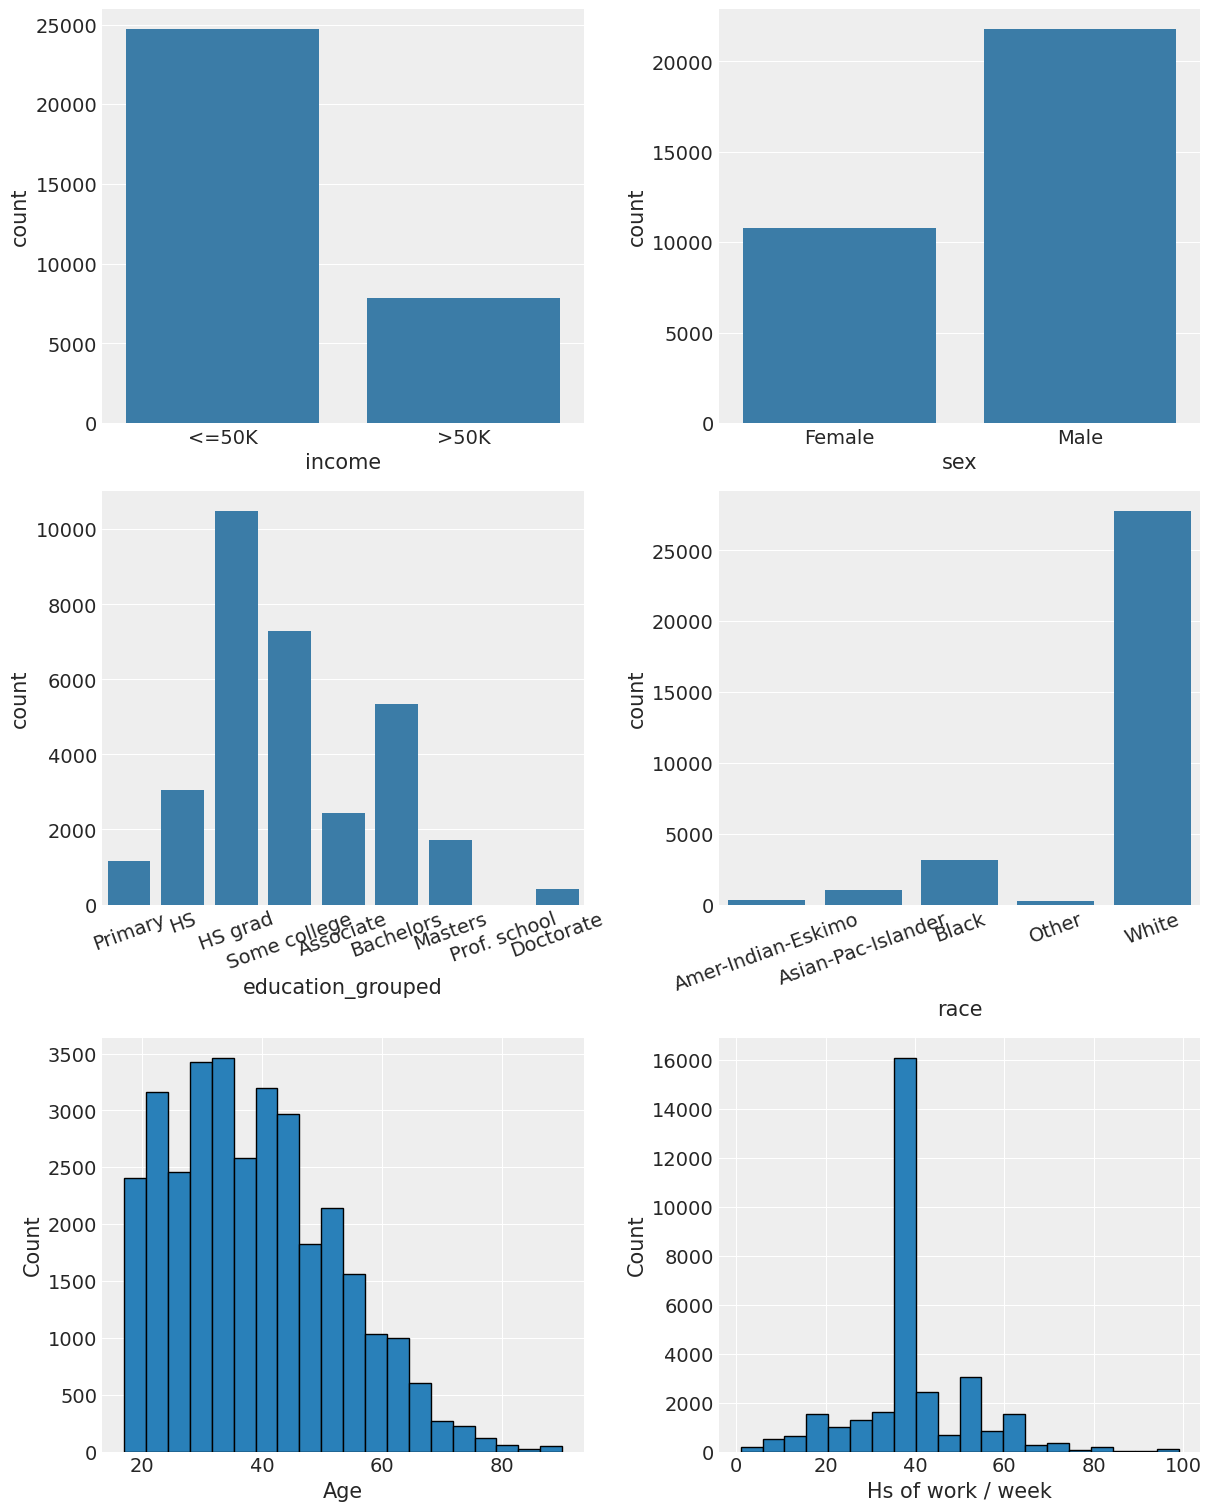

In [9]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", color=BLUE, data=data, ax=axes[0, 1]);
sns.countplot(x="race", color=BLUE, data=data, ax=axes[1, 1]);
axes[1, 1].tick_params(axis="x", rotation=20) 
sns.countplot(x="education_grouped", color=BLUE, data=data, ax=axes[1, 0]);
axes[1, 0].tick_params(axis="x", rotation=20) 
axes[2, 0].hist(data["age"], bins=20, edgecolor="black", color=BLUE);
axes[2, 0].set_xlabel("Age")
axes[2, 0].set_ylabel("Count")
axes[2, 1].hist(data["hs_week"], bins=20, edgecolor="black", color=BLUE);
axes[2, 1].set_xlabel("Hs of work / week")
axes[2, 1].set_ylabel("Count");

We only keep the races black and white to simplify the analysis because the other categories don't appear very often in our data. 

Now, we see the distribution of income for the different levels of our explanatory variables. Numerical variables are binned to make the analysis possible.

In [10]:
data = data[data["race"].isin(["Black", "White"])]
data["race"] = data["race"].cat.remove_unused_categories()
age_bins = [17, 25, 35, 45, 65, 90]
data["age_binned"] = pd.cut(data["age"], age_bins)
hours_bins = [0, 20, 40, 60, 100]
data["hs_week_binned"] = pd.cut(data["hs_week"], hours_bins) 

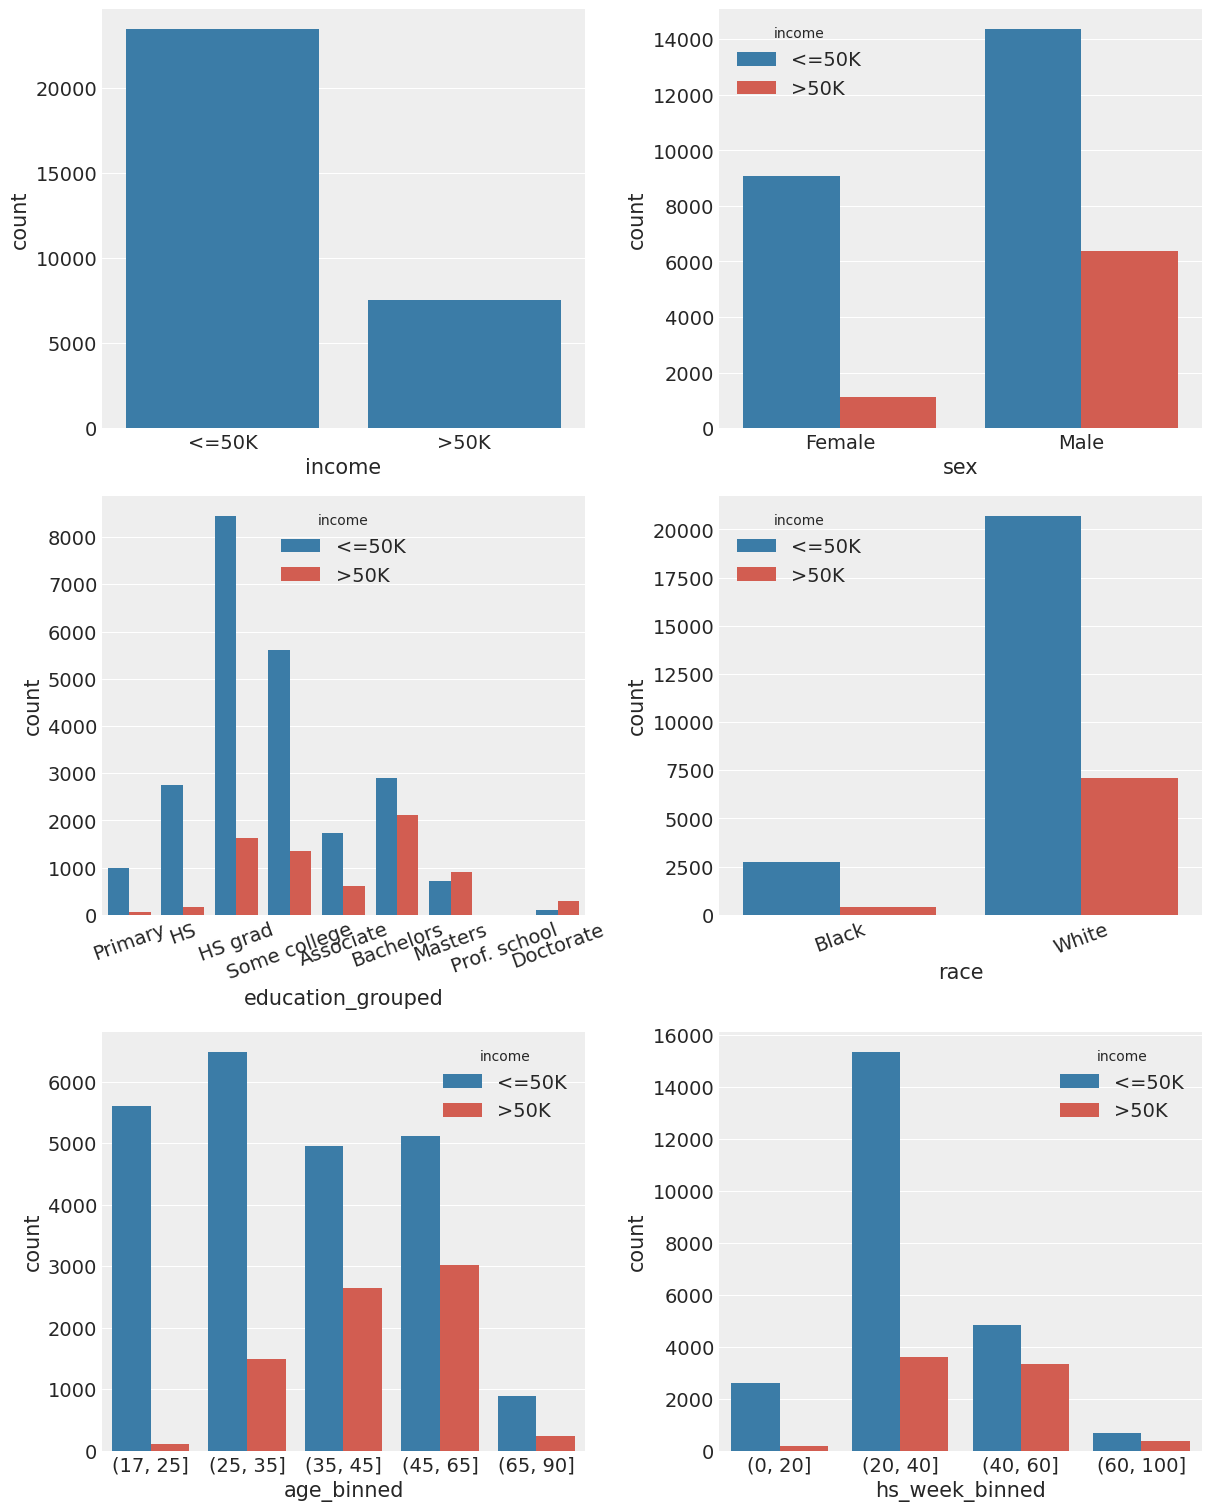

In [11]:
fig, axes = plt.subplots(3, 2, figsize=(12, 15))
sns.countplot(x="income", color=BLUE, data=data, ax=axes[0, 0])
sns.countplot(x="sex", hue="income", palette=[BLUE, RED], data=data, ax=axes[0, 1]);
sns.countplot(x="education_grouped", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 0])
axes[1, 0].tick_params(axis="x", rotation=20)
sns.countplot(x="race", hue="income", palette=[BLUE, RED], data=data, ax=axes[1, 1])
axes[1, 1].tick_params(axis="x", rotation=20) 
sns.countplot(x="age_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[2, 0])
sns.countplot(x="hs_week_binned", hue="income", palette=[BLUE, RED], data=data, ax=axes[2, 1]);

Some data preparation before fitting our model. It is very important we express everything in a numerical way. Categorical variables are expressed with dummy variables. It is clearer for the variable 'education' which has 4 levels and consequently 3 dummy variables are used to represent it.

In [12]:
data["sex"] = np.where(data["sex"] == "Female", 1, 0)
data["race"] = np.where(data["race"] == "White", 1, 0)
data["age"] = data["age"] / 10 # scaling helps with model convergence
data["age2"] = data["age"] ** 2
data["age3"] = data["age"] ** 3
data["hs_week"] = data["hs_week"] / 10 # scaling helps with model convergence
data["hs_week2"] = data["hs_week"] ** 2
data["hs_week3"] = data["hs_week"] ** 3
data["income"] = np.where(data["income"] == ">50K", 1, 0)

# Baseline: primary and high school -> Those who did not finish secondary school
hs = ["HS grad", "Some college"]
undergrad = ["Associate", "Bachelors"]
grad = ["Masters", "Doctorate", "Prof. school"]

data["education_hs"] = np.where(data["education_grouped"].isin(hs), 1, 0)
data["education_undergrad"] = np.where(data["education_grouped"].isin(undergrad), 1, 0)
data["education_grad"] = np.where(data["education_grouped"].isin(grad), 1, 0)

## The model

We will use a logistic regression model to estimate the probability of making more than $50K as a function of age, hours of work per week, sex, race and education level. We will use PyMC3 to do the inference.

If we have a binary response variable $Y$ and a set of predictors or explanatory variables $X_1, X_2, \cdots, X_p$ the logistic regression model can be defined as follows:

$$\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \cdots + \beta_p X_p$$

where $\pi = P(Y = 1)$ (a.k.a. probability of success) and $\beta_0, \beta_1, \cdots \beta_p$ are unknown parameters. The term on the left side is the logarithm of the odds ratio or simply known as the log-odds. With little effort, the expression can be re-arranged to express our probability of interest, $\pi$, as a function of the betas and the predictors.

$$
\pi = \frac{e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}
    = \frac{1}{1 + e^{\beta_0 + \beta_1 X_1 + \cdots + \beta_p X_p}}
$$

We need to specify a prior and a likelihood in order to draw samples from the posterior distribution. We could use sociological knowledge about the effects of age and education on income, but instead, let’s use the default prior specification for GLM coefficients that PyMC3 gives us, which is $p(\theta) = N(0,10^{3}I)$, which is a very vague prior.

The likelihood is the product of $n$ Bernoulli trials, $\prod_{i=1}^{n}{p_i^y(1-p_i)^{1-y_i}}$ where $p_i = P(Y=1)$

With the math out of the way we can get back to the data. Here I use PyMC3 to draw samples from the posterior. The sampling algorithm used is NUTS, which is a form of Hamiltonian Monte Carlo, in which parameteres are tuned automatically. Notice, that we get to borrow the syntax of specifying GLM’s from R.

$$Y = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person makes more than 50K per year} \\
        0 & \textrm{if the person makes less than 50K per year} 
    \end{array}
\right.
$$

$$\pi = P(Y=1)$$

## Model 1:

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 + \beta_4 X_4   
$$

Where:

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is female} \\
        0 & \textrm{if the person is male} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. \\
$ 


In [13]:
model_str = " + ".join((
    "income ~ age",
    "hs_week",
    "sex",
    "race"
))

with pm.Model() as model1:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace1 = pm.sample(1000, tune=1000, init="adapt_diag", model=model1)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [race, sex, hs_week, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 97 seconds.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept -4.906  0.095  -5.074   -4.721      0.003    0.002     851.0   
age        0.423  0.011   0.404    0.444      0.000    0.000    1443.0   
hs_week    0.408  0.012   0.388    0.435      0.000    0.000    1231.0   
sex       -1.017  0.037  -1.082   -0.945      0.001    0.001    1476.0   
race       0.633  0.060   0.525    0.748      0.002    0.001    1288.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept   851.0     852.0     883.0    1.0  
age        1443.0    1444.0    1112.0    1.0  
hs_week    1229.0    1230.0    1243.0    1.0  
sex        1476.0    1476.0    1172.0    1.0  
race       1288.0    1289.0    1223.0    1.0

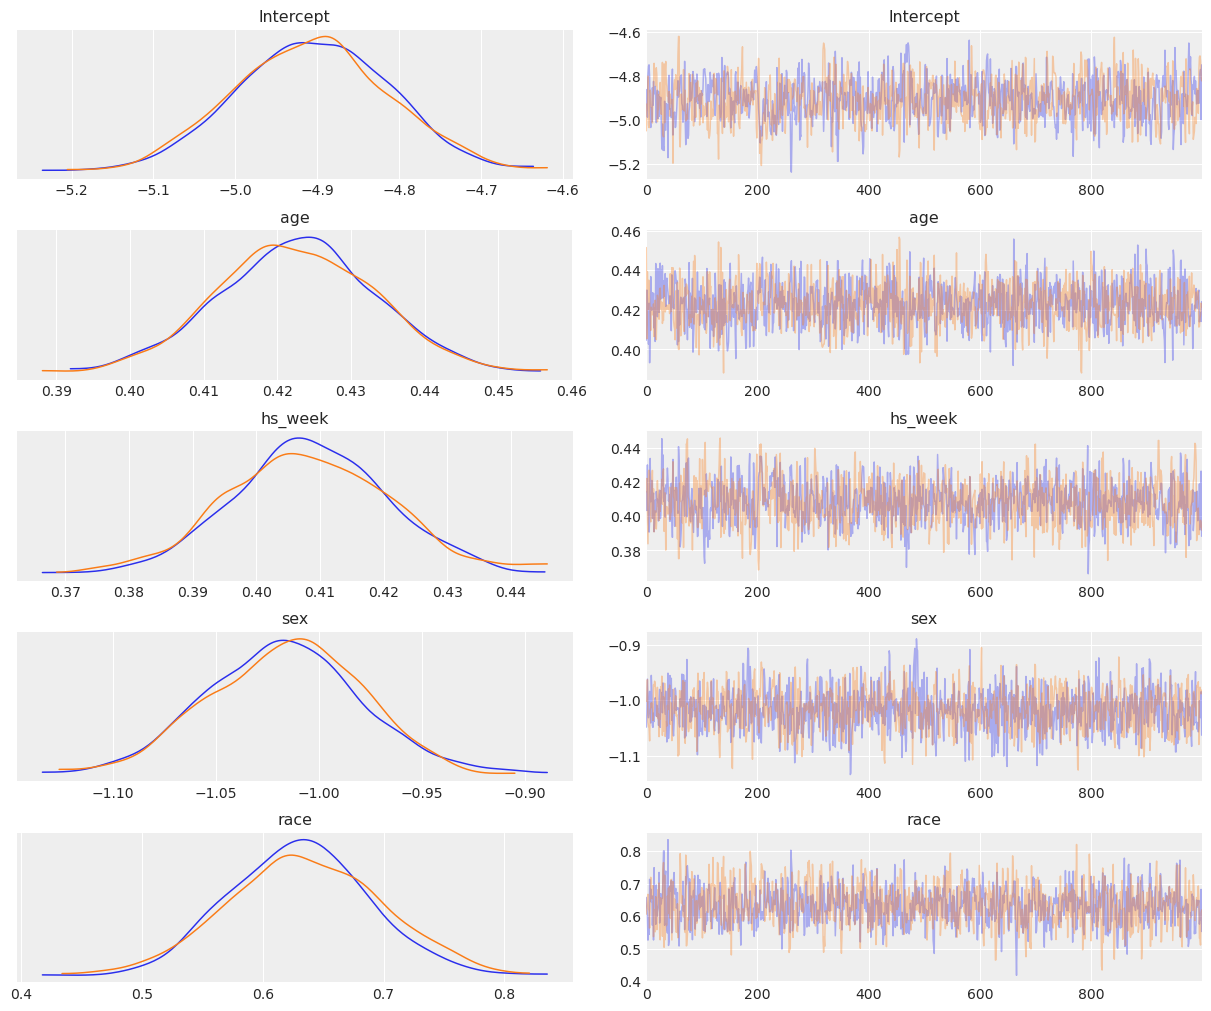

In [14]:
az.plot_trace(trace1);
az.summary(trace1)

## Model 2

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_2 + \beta_3 X_3 
                                       + \beta_4 X_4 + \beta_5 X_5
                                       + \beta_6 X_6 + \beta_7 X_7 
$$

Where:

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is female} \\
        0 & \textrm{if the person is male} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. \\ 
X_5 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person at most started an undergraduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. \\ 
X_6 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person graduated from an undergraduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. \\ 
X_7 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person graduated from a graduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. 
$

In [15]:
model_str = " + ".join((
    "income ~ age",
    "hs_week",
    "sex",
    "race",
    "education_hs",
    "education_undergrad",
    "education_grad"
))

with pm.Model() as model2:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace2 = pm.sample(1000, tune=1000, init='adapt_diag', model=model2)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [education_grad, education_undergrad, education_hs, race, sex, hs_week, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 123 seconds.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           -5.486  0.108  -5.692   -5.296      0.004    0.003   
age                  0.434  0.011   0.413    0.455      0.000    0.000   
hs_week              0.375  0.013   0.351    0.399      0.000    0.000   
sex                 -1.140  0.040  -1.216   -1.063      0.001    0.001   
race                 0.484  0.062   0.365    0.600      0.002    0.001   
education_hs         0.451  0.051   0.356    0.546      0.002    0.001   
education_undergrad  1.490  0.054   1.392    1.591      0.002    0.001   
education_grad       2.195  0.069   2.064    2.323      0.002    0.001   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               769.0   769.0     769.0     990.0    1.0  
age                    1256.0  1256.0    1253.0    1186.0    1.0  
hs_week                1273.0  1273.0    1269.0    1379.0    1.0  
sex                    1665.0  1658.0    1674.0    1111.0    1.0  
race                   1505.0  1424.0    1517.0    1157.0    1.0  
education_hs           1042.0  1033.0    1046.0    1234.0    1.0  
education_undergrad    1041.0  1039.0    1041.0    1280.0    1.0  
education_grad         1143.0  1141.0    1153.0    1403.0    1.0

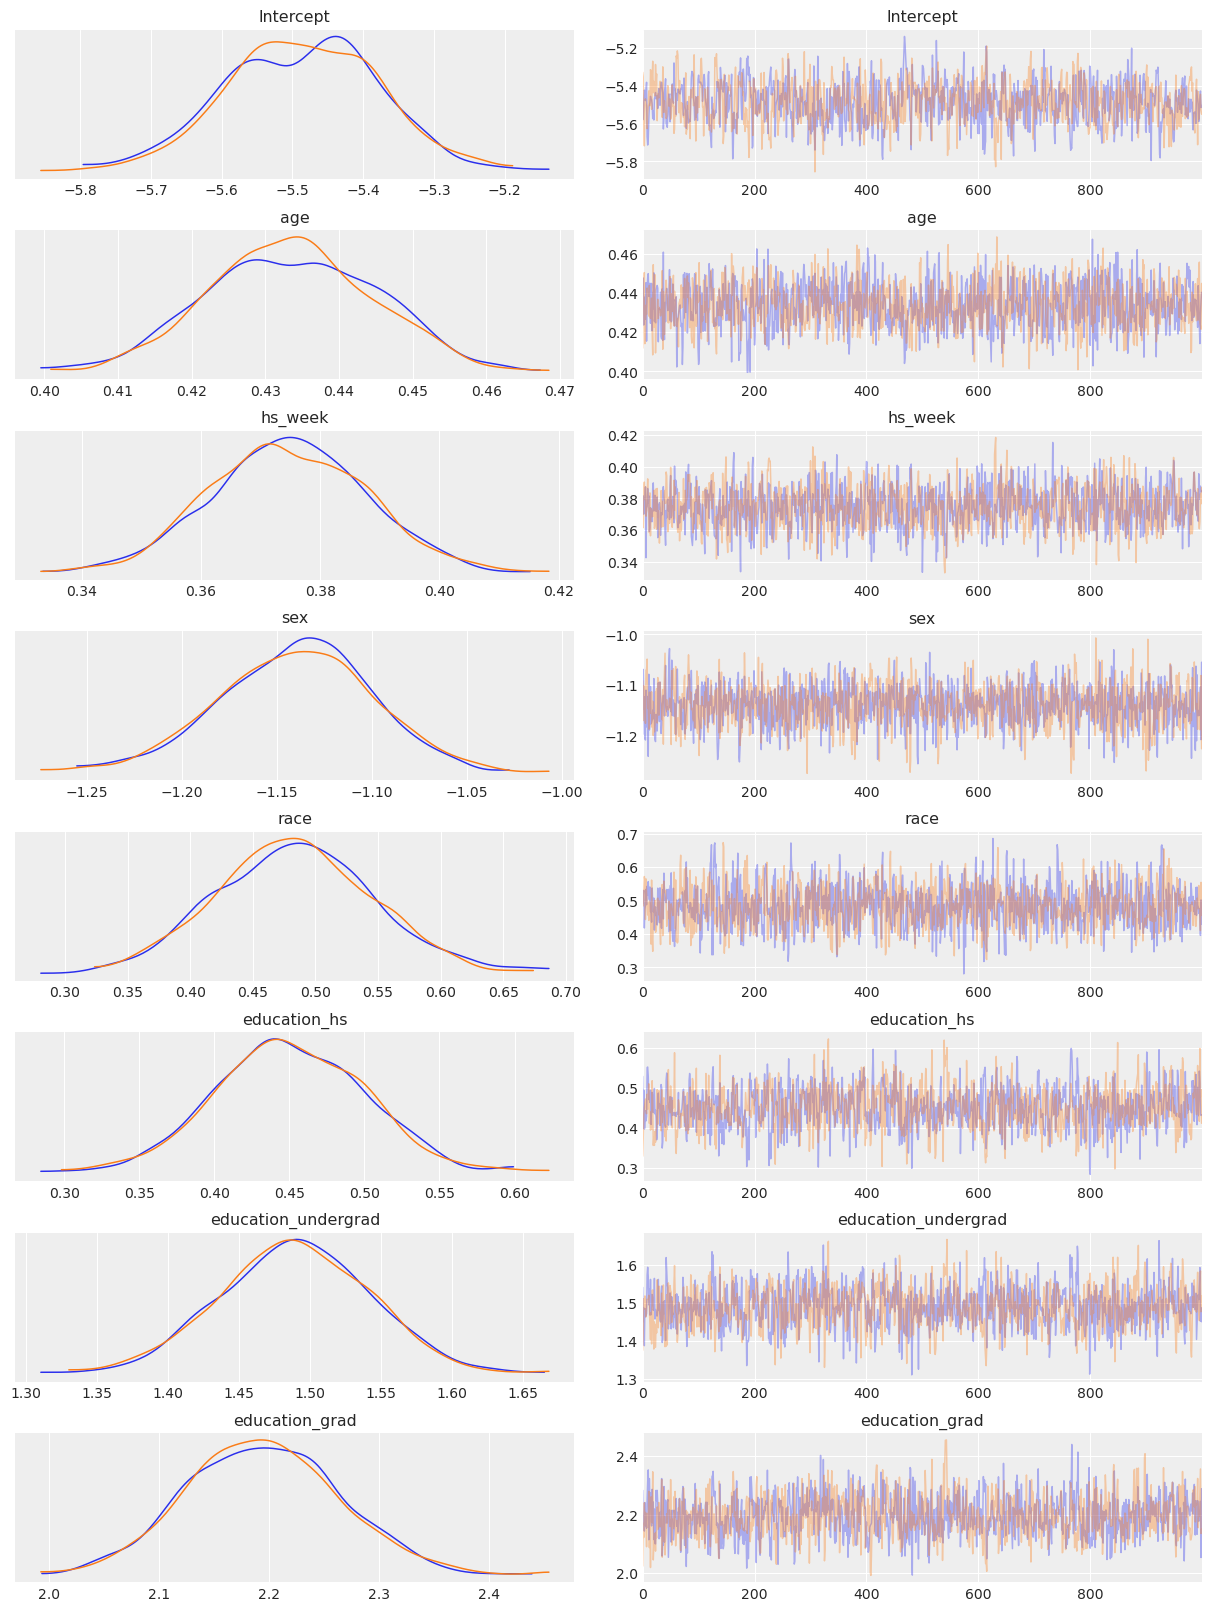

In [16]:
az.plot_trace(trace2);
az.summary(trace2)

## Model 3

$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_2 + \beta_4 X_2^2
                                         + \beta_5 X_3 + \beta_6 X_4
$$

Where: 

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is female} \\
        0 & \textrm{if the person is male} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. 
$

In [17]:
model_str = " + ".join((
    "income ~ age",
    "age2",
    "hs_week",
    "hs_week2",
    "sex",
    "race"
))

with pm.Model() as model3:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace3 = pm.sample(1000, tune=1000, init="adapt_diag", model=model3)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [race, sex, hs_week2, hs_week, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 382 seconds.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_mean  \
Intercept -11.165  0.210 -11.560  -10.771      0.007    0.005     895.0   
age         3.003  0.081   2.842    3.146      0.003    0.002     892.0   
age2       -0.287  0.009  -0.303   -0.269      0.000    0.000     909.0   
hs_week     0.868  0.058   0.758    0.971      0.002    0.001     935.0   
hs_week2   -0.057  0.006  -0.067   -0.046      0.000    0.000     966.0   
sex        -1.006  0.040  -1.076   -0.925      0.001    0.001    1503.0   
race        0.702  0.060   0.591    0.815      0.002    0.001    1201.0   

           ess_sd  ess_bulk  ess_tail  r_hat  
Intercept   893.0     896.0    1022.0   1.00  
age         889.0     893.0    1132.0   1.00  
age2        906.0     908.0    1122.0   1.00  
hs_week     932.0     941.0     956.0   1.00  
hs_week2    961.0     972.0    1071.0   1.01  
sex        1503.0    1508.0    1149.0   1.00  
race       1201.0    1196.0    1086.0   1.00

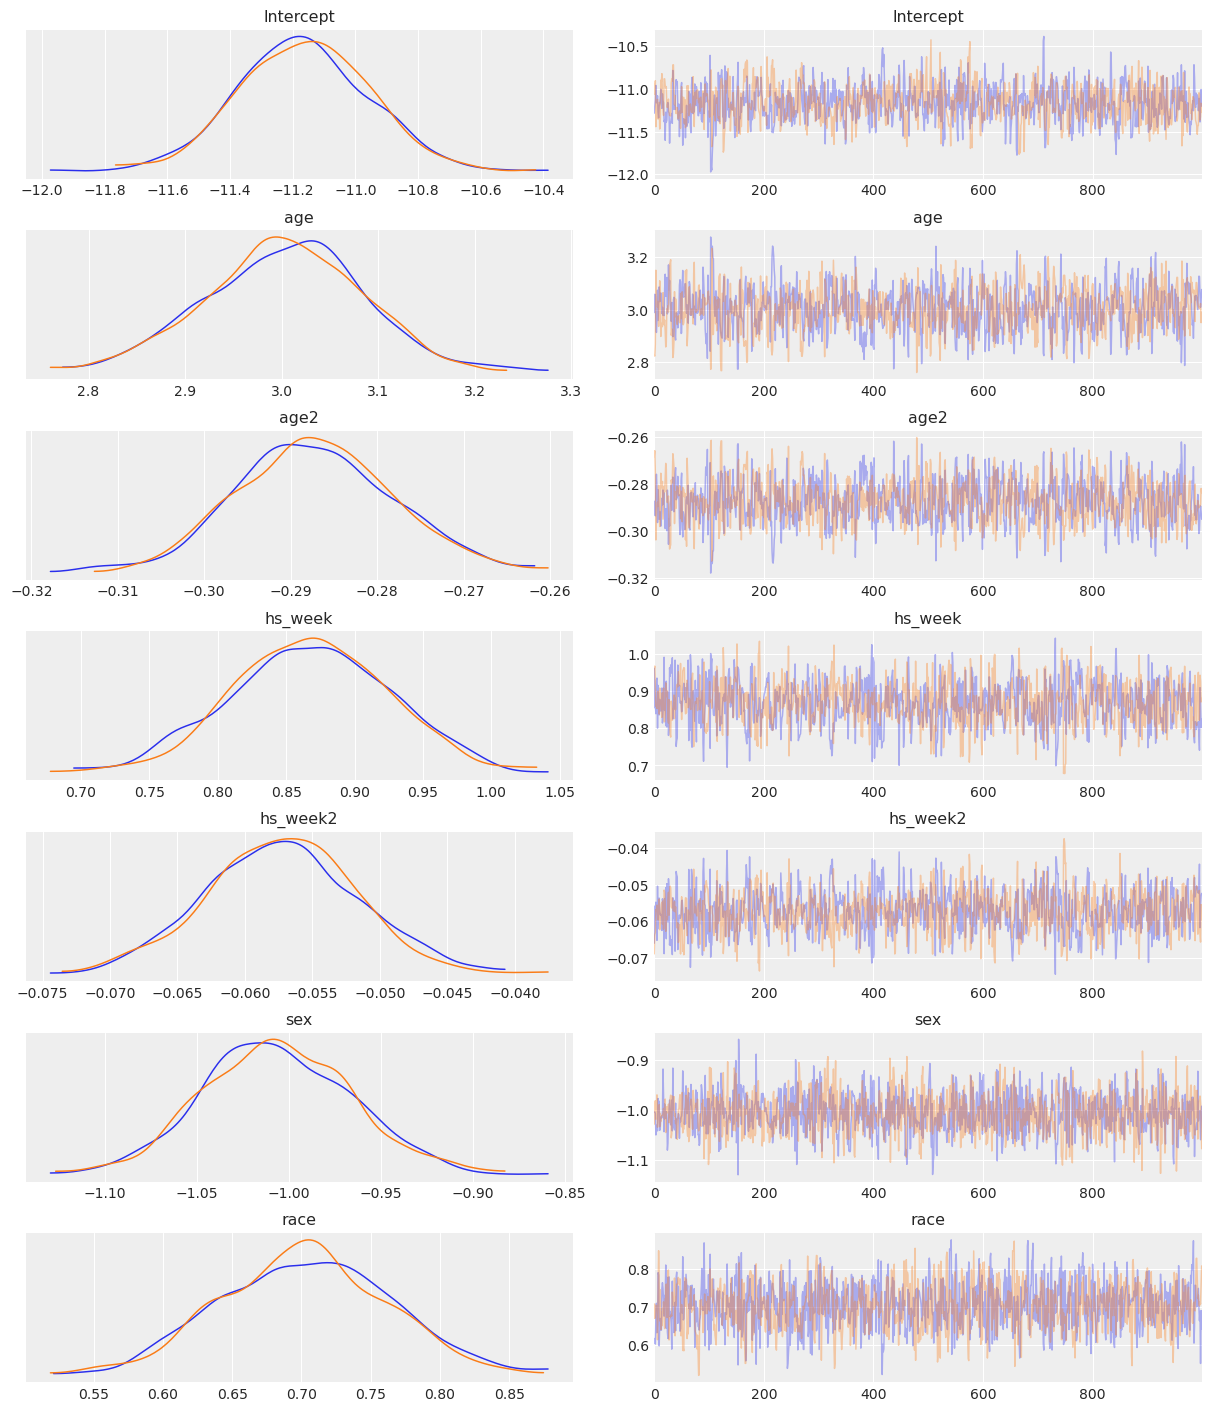

In [18]:
az.plot_trace(trace3);
az.summary(trace3)

## Model 4


$$
\log{\left(\frac{\pi}{1 - \pi}\right)} = \beta_0 + \beta_1 X_1 + \beta_2 X_1^2 + \beta_3 X_2 + \beta_4 X_2 ^2 
                                         + \beta_5 X_3 + \beta_6 X_4 + \beta_7 X_5
                                         + \beta_8 X_6 + \beta_9 X_7  
$$

Where: 

$
X_1 = \textrm{Age / 10} \\
X_2 = \textrm{Hours of work per week / 10} \\
X_3 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is female} \\
        0 & \textrm{if the person is male} 
    \end{array}
\right. \\
X_4 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person is white} \\
        0 & \textrm{if the person is black} 
    \end{array}
\right. \\
X_5 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person at most started an undergraduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. \\ 
X_6 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person graduated from an undergraduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. \\ 
X_7 = 
\left\{ 
    \begin{array}{ll}
        1 & \textrm{if the person graduated from a graduate career} \\
        0 & \textrm{other case} 
    \end{array}
\right. 
$

In [19]:
model_str = " + ".join((
    "income ~ age",
    "age2",
    "hs_week",
    "hs_week2",
    "sex",
    "race",
    "education_hs",
    "education_undergrad",
    "education_grad"
))

with pm.Model() as model4:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace4 = pm.sample(1000, tune=1000, init='adapt_diag', model=model4)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [education_grad, education_undergrad, education_hs, race, sex, hs_week2, hs_week, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 464 seconds.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           -11.250  0.221 -11.662  -10.844      0.008    0.005   
age                   2.842  0.085   2.687    3.004      0.003    0.002   
age2                 -0.267  0.009  -0.285   -0.249      0.000    0.000   
hs_week               0.801  0.058   0.698    0.915      0.002    0.001   
hs_week2             -0.053  0.006  -0.063   -0.042      0.000    0.000   
sex                  -1.121  0.041  -1.198   -1.048      0.001    0.001   
race                  0.562  0.061   0.441    0.674      0.002    0.001   
education_hs          0.335  0.053   0.232    0.433      0.002    0.001   
education_undergrad   1.339  0.057   1.235    1.448      0.002    0.001   
education_grad        2.000  0.071   1.862    2.123      0.002    0.002   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               841.0   841.0     844.0    1170.0   1.00  
age                     915.0   915.0     914.0    1201.0   1.00  
age2                    929.0   929.0     926.0    1300.0   1.00  
hs_week                 996.0   994.0     998.0    1030.0   1.01  
hs_week2               1011.0  1005.0    1016.0    1129.0   1.01  
sex                    1943.0  1943.0    1932.0    1526.0   1.00  
race                   1111.0  1111.0    1101.0    1040.0   1.00  
education_hs            952.0   917.0     960.0     972.0   1.00  
education_undergrad     962.0   956.0     966.0    1269.0   1.00  
education_grad         1111.0  1107.0    1112.0    1232.0   1.00

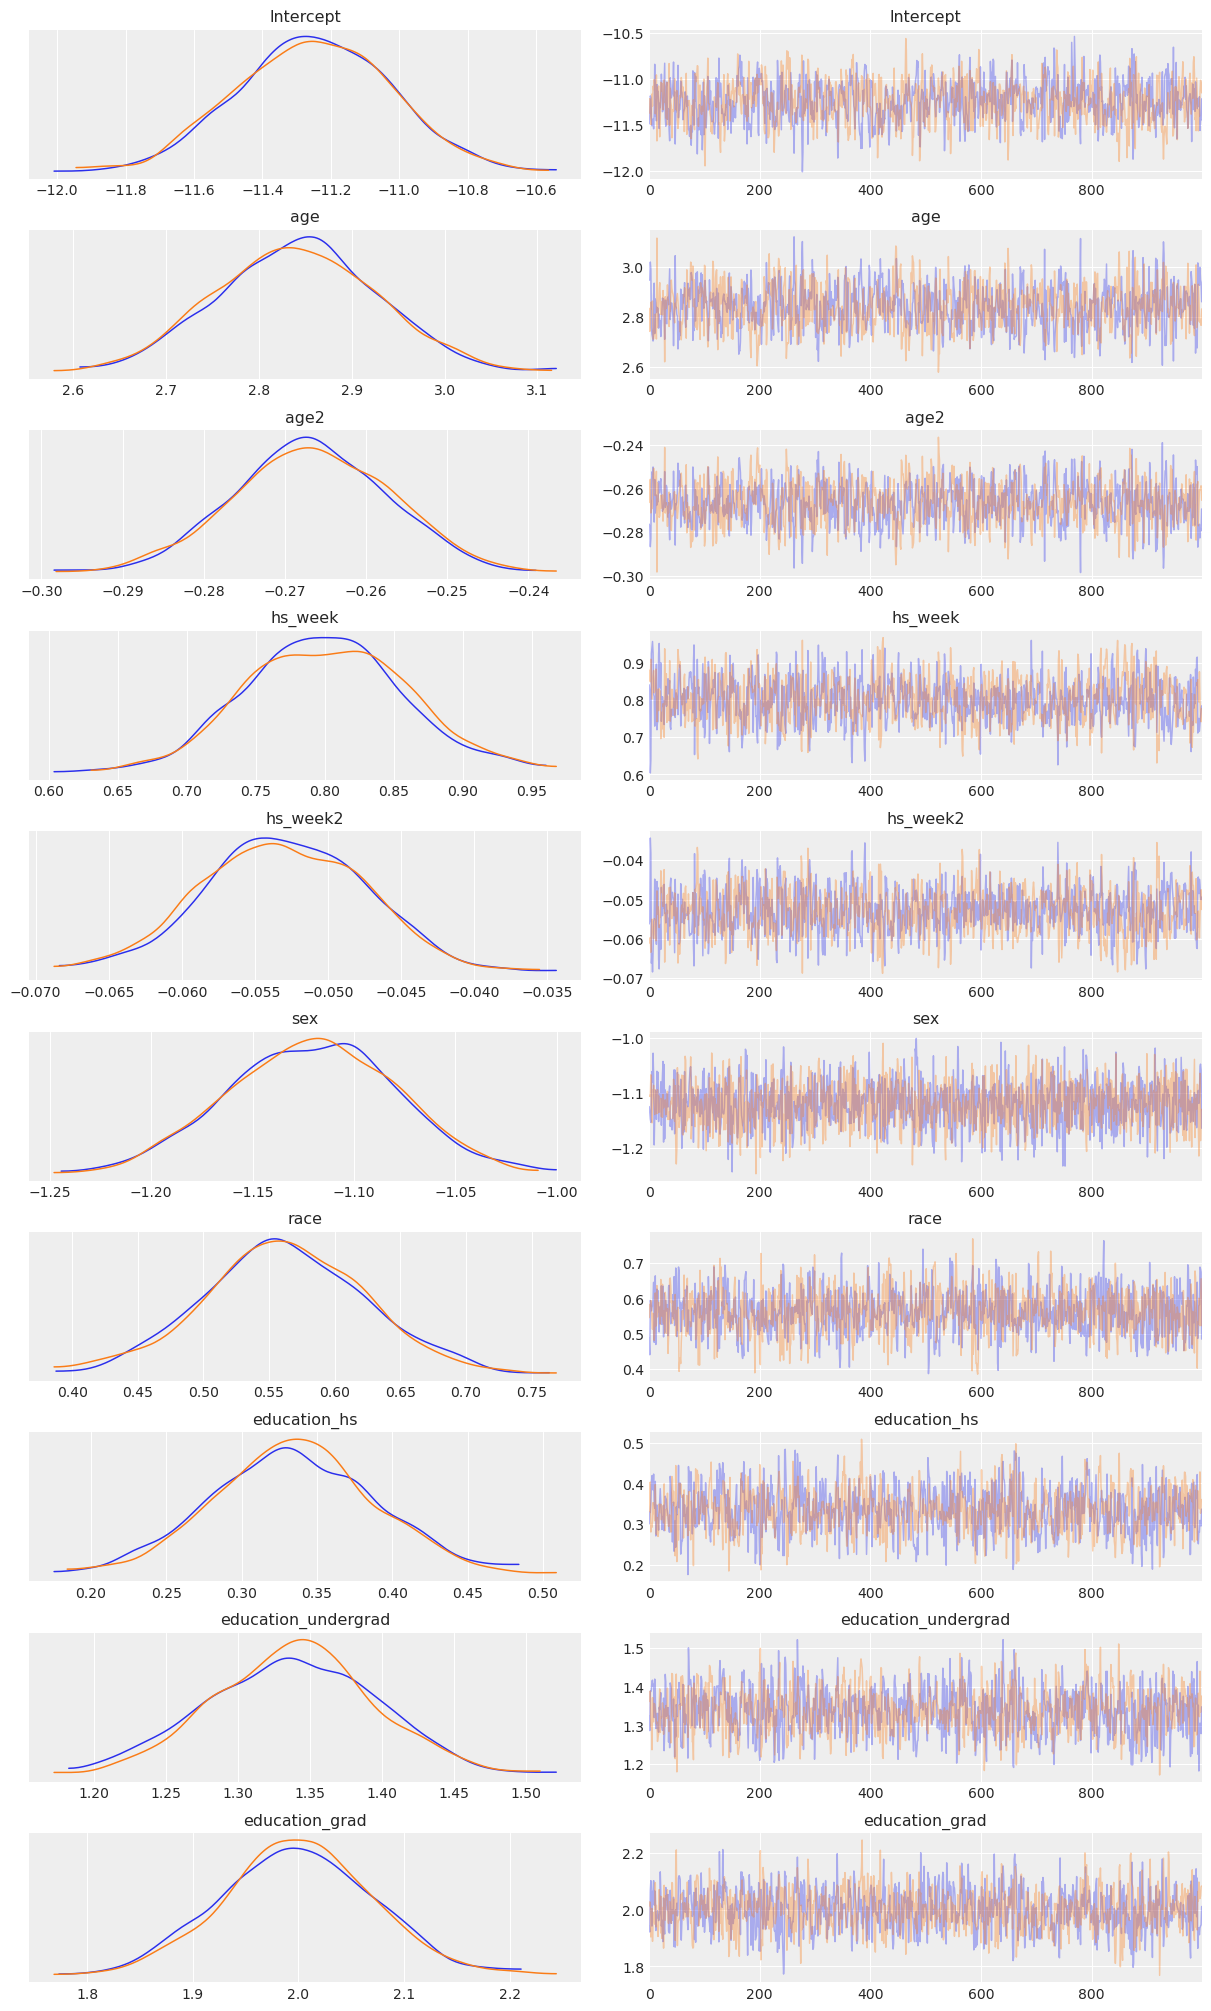

In [20]:
az.plot_trace(trace4);
az.summary(trace4)

In [21]:
model_str = " + ".join((
    "income ~ age",
    "age2",
    "age3",
    "hs_week",
    "hs_week2",
    "sex",
    "race",
    "education_hs",
    "education_undergrad",
    "education_grad"
))

with pm.Model() as model5:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace5 = pm.sample(1000, tune=1000, init='adapt_diag', model=model5)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [education_grad, education_undergrad, education_hs, race, sex, hs_week2, hs_week, age3, age2, age, Intercept]


Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1646 seconds.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           -16.968  0.495 -17.846  -15.979      0.018    0.013   
age                   6.877  0.315   6.262    7.433      0.012    0.008   
age2                 -1.155  0.065  -1.277   -1.036      0.002    0.002   
age3                  0.062  0.004   0.054    0.070      0.000    0.000   
hs_week               0.797  0.055   0.696    0.900      0.002    0.001   
hs_week2             -0.053  0.005  -0.063   -0.043      0.000    0.000   
sex                  -1.115  0.040  -1.192   -1.041      0.001    0.001   
race                  0.569  0.061   0.448    0.679      0.001    0.001   
education_hs          0.320  0.051   0.223    0.416      0.002    0.001   
education_undergrad   1.308  0.056   1.207    1.415      0.002    0.001   
education_grad        1.958  0.070   1.827    2.086      0.002    0.002   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               735.0   735.0     729.0    1113.0   1.00  
age                     695.0   695.0     692.0    1000.0   1.00  
age2                    705.0   705.0     702.0     897.0   1.00  
age3                    726.0   726.0     726.0     908.0   1.00  
hs_week                1114.0  1111.0    1113.0    1227.0   1.00  
hs_week2               1126.0  1122.0    1129.0    1100.0   1.00  
sex                    1157.0  1151.0    1171.0    1067.0   1.01  
race                   1721.0  1721.0    1708.0    1300.0   1.00  
education_hs            749.0   749.0     748.0    1152.0   1.00  
education_undergrad     773.0   773.0     773.0    1117.0   1.00  
education_grad          862.0   862.0     863.0    1175.0   1.00

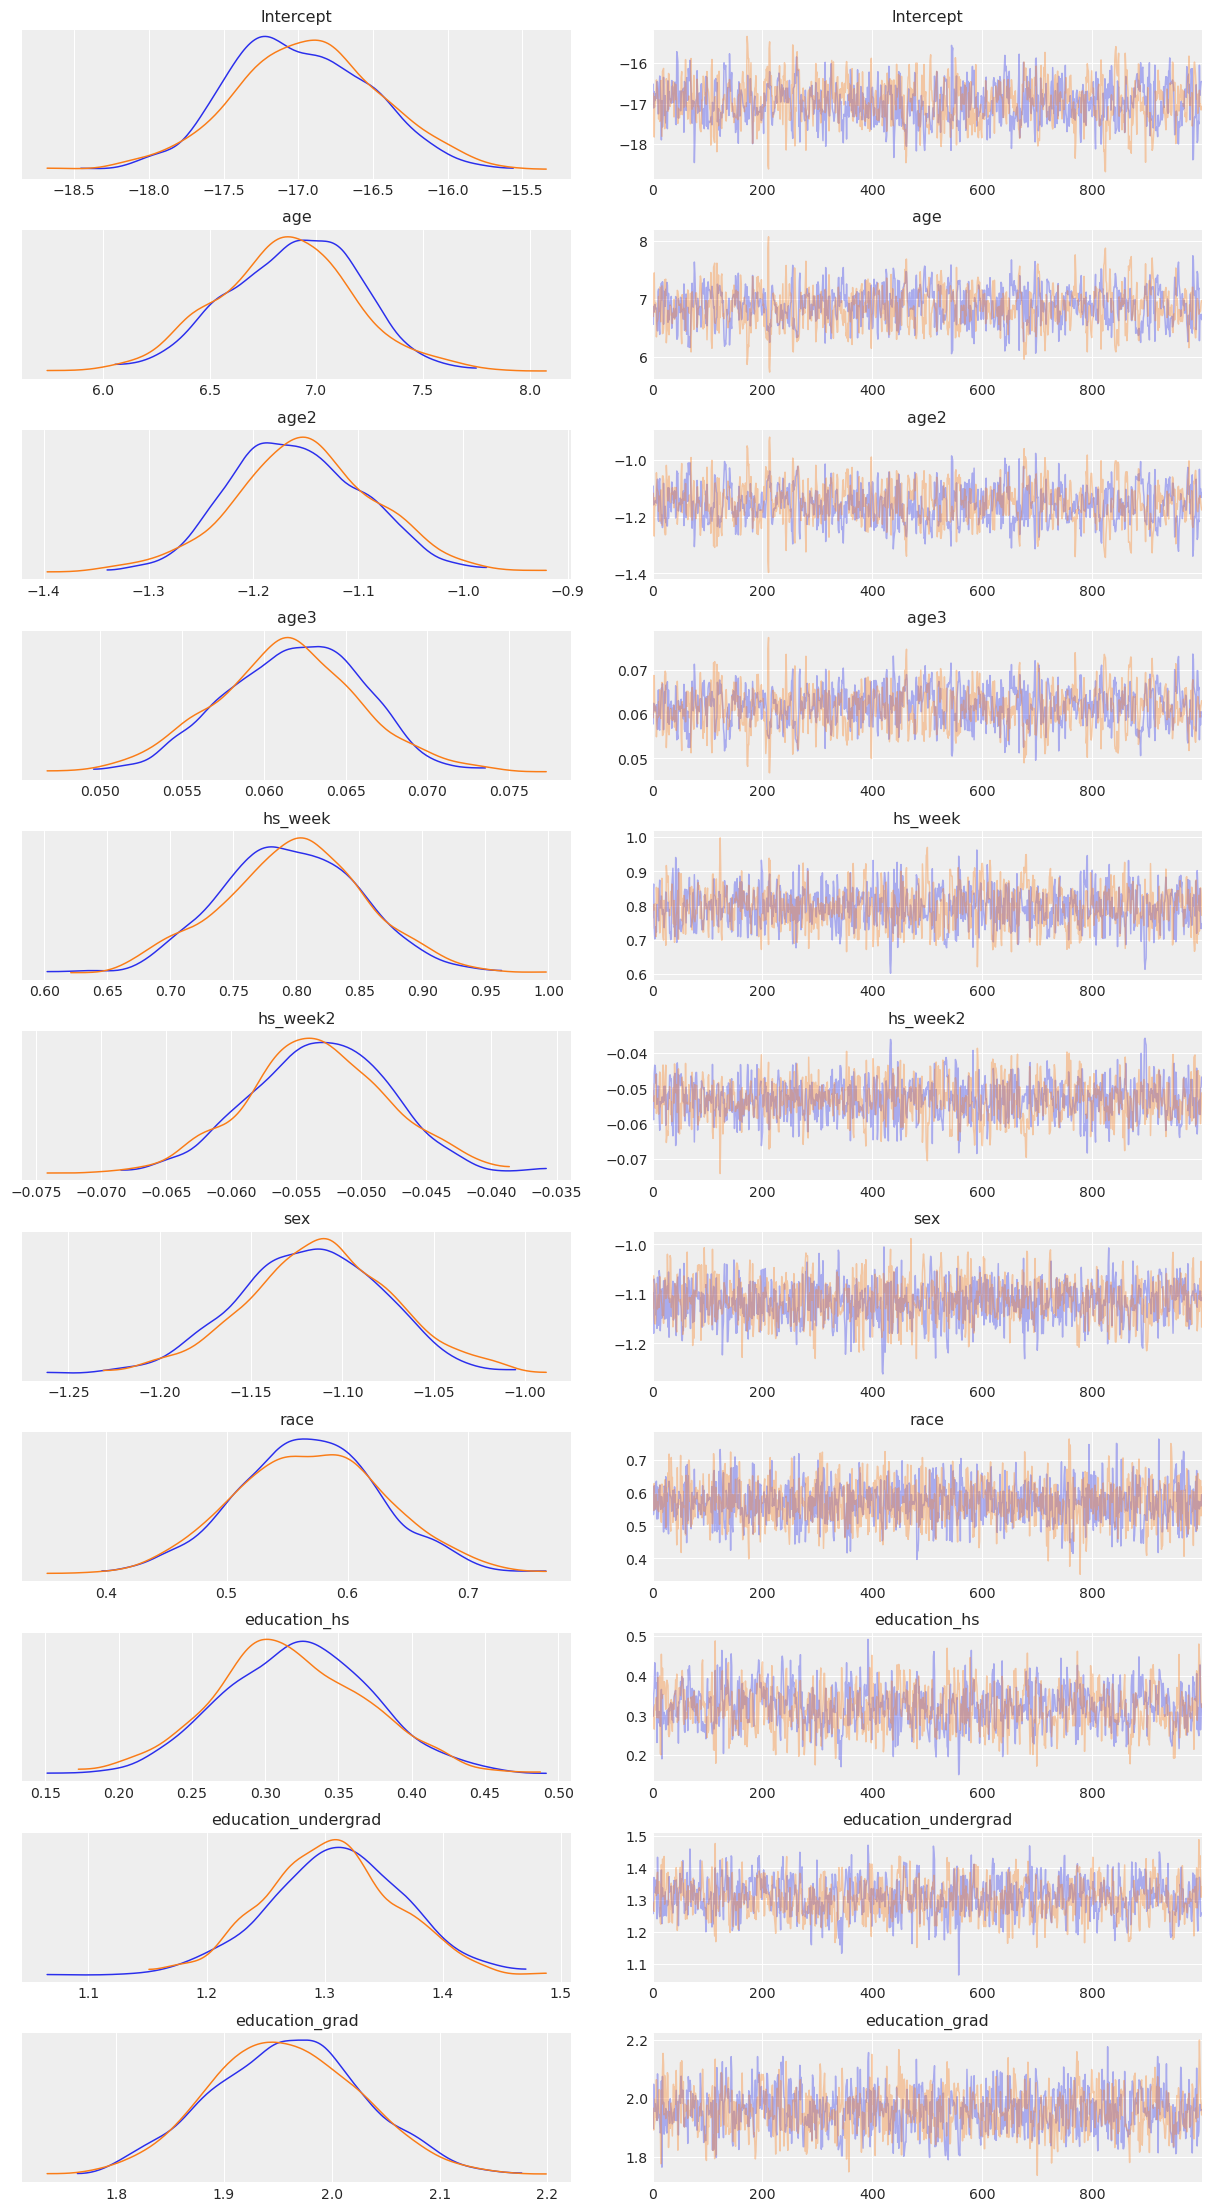

In [22]:
az.plot_trace(trace5);
az.summary(trace5)

In [26]:
model_str = " + ".join((
    "income ~ age",
    "age2",
    "age3",
    "hs_week",
    "hs_week2",
    "hs_week3",
    "sex",
    "race",
    "education_hs",
    "education_undergrad",
    "education_grad"
))

with pm.Model() as model6:
    pm.glm.GLM.from_formula(
        formula = model_str,
        data = data,
        family = pm.glm.families.Binomial())
    trace6 = pm.sample(1000, tune=2000, init='adapt_diag', model=model6)

Auto-assigning NUTS sampler...
Initializing NUTS using adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [education_grad, education_undergrad, education_hs, race, sex, hs_week3, hs_week2, hs_week, age3, age2, age, Intercept]


Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 2616 seconds.
The acceptance probability does not match the target. It is 0.8856403088542363, but should be close to 0.8. Try to increase the number of tuning steps.


/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  \
Intercept           -15.740  0.529 -16.762  -14.786      0.023    0.016   
age                   6.861  0.312   6.299    7.471      0.014    0.010   
age2                 -1.148  0.064  -1.267   -1.026      0.003    0.002   
age3                  0.061  0.004   0.052    0.068      0.000    0.000   
hs_week              -0.134  0.129  -0.376    0.107      0.004    0.003   
hs_week2              0.159  0.028   0.106    0.211      0.001    0.001   
hs_week3             -0.014  0.002  -0.018   -0.011      0.000    0.000   
sex                  -1.098  0.039  -1.170   -1.024      0.001    0.001   
race                  0.550  0.061   0.427    0.658      0.002    0.001   
education_hs          0.314  0.050   0.223    0.407      0.001    0.001   
education_undergrad   1.292  0.055   1.189    1.393      0.001    0.001   
education_grad        1.933  0.067   1.806    2.053      0.002    0.001   

                     ess_mean  ess_sd  ess_bulk  ess_tail  r_hat  
Intercept               521.0   518.0     527.0     654.0   1.00  
age                     522.0   520.0     523.0     639.0   1.01  
age2                    509.0   507.0     510.0     642.0   1.01  
age3                    508.0   505.0     508.0     698.0   1.00  
hs_week                 999.0   981.0     999.0    1043.0   1.00  
hs_week2                922.0   922.0     932.0     943.0   1.00  
hs_week3                914.0   914.0     921.0     952.0   1.00  
sex                    1688.0  1682.0    1696.0    1435.0   1.00  
race                   1602.0  1585.0    1611.0    1304.0   1.00  
education_hs           1325.0  1325.0    1340.0    1437.0   1.00  
education_undergrad    1339.0  1339.0    1348.0    1202.0   1.00  
education_grad         1313.0  1309.0    1318.0    1248.0   1.00

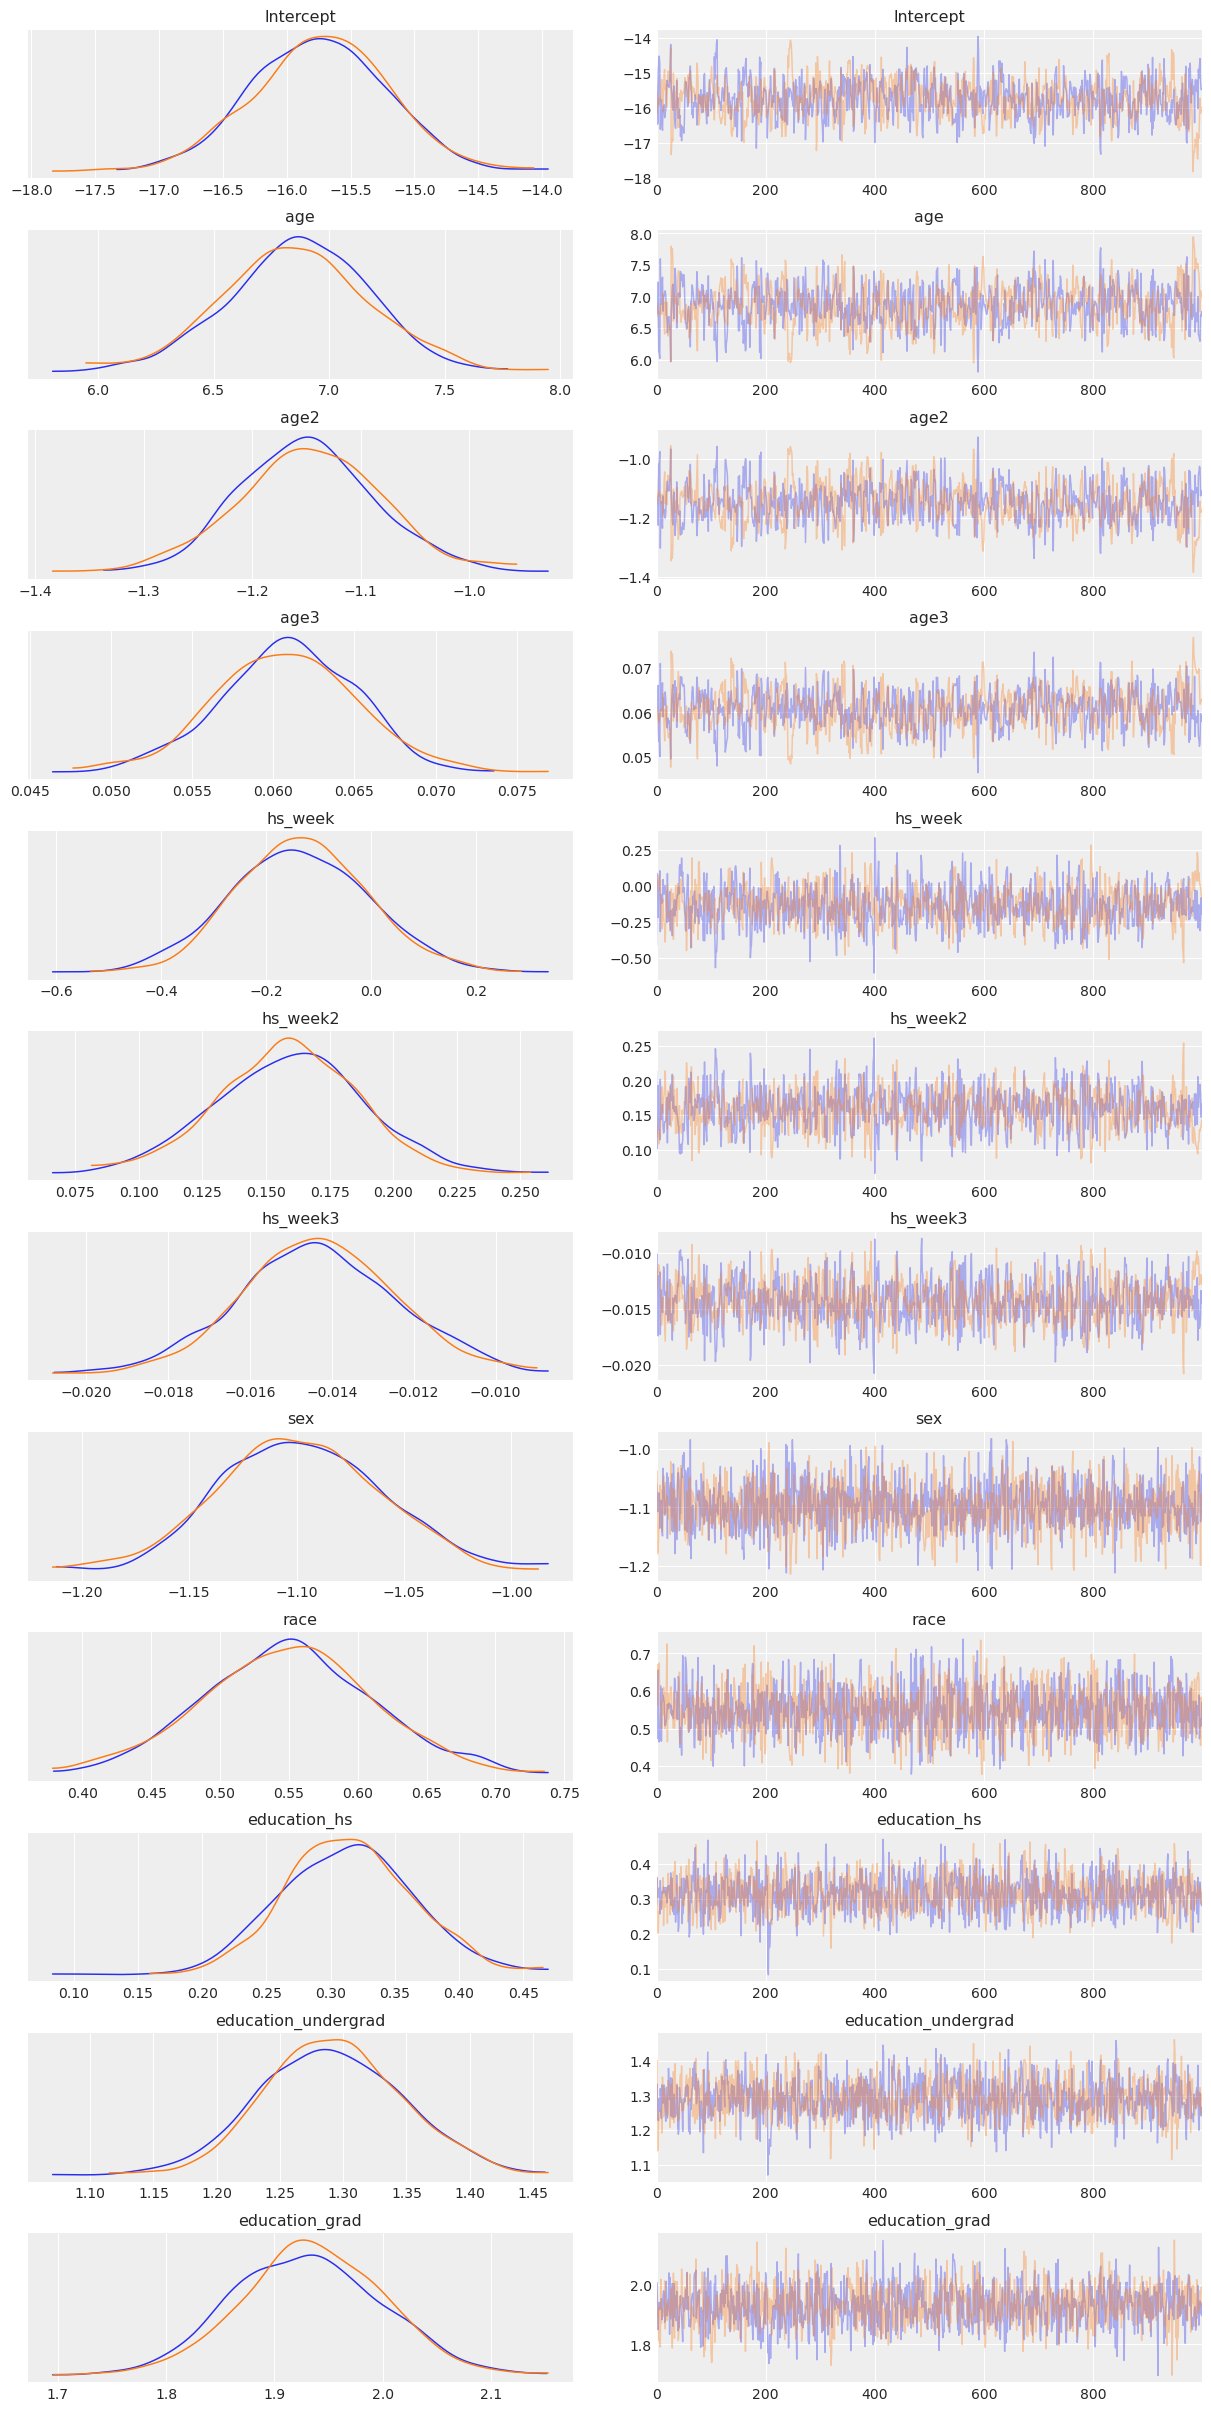

In [27]:
az.plot_trace(trace6);
az.summary(trace6)

### Note

None of the traceplots show any alarming behavior behavior and we don't have any divergences. In all the cases the pattern is stationary and the different traces mixed well. However, when sampling for model6 the acceptance probability was higher than the desired value of 0.8. As suggested, more tuning steps could be added.

## Model comparison

In [28]:
models_dict = {
    "model1": trace1,
    "model2": trace2,
    "model3": trace3,
    "model4": trace4,
    "model5": trace5,
    "model6": trace6
}
df_compare = az.compare(models_dict)
df_compare

/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/stats/stats.py:150: UserWarning: 
The scale is now log by default. Use 'scale' argument or 'stats.ic_scale' rcParam if you rely on a specific value.
A higher log-score (or a lower deviance) indicates a model with better predictive accuracy.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(
/home/tomas/anaconda3/envs/pymc39/lib/python3.8/site-packages/arviz/data/io_pymc3.py:85: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model co

rank      loo    p_loo    d_loo weight       se      dse warning  \
model6    0 -13167.6  12.3116        0    NaN  91.7414        0   False   
model5    1 -13196.8  11.3297  29.2184    NaN  92.6262  8.74046   False   
model4    2   -13283  10.7714  115.457    NaN  96.6869  16.0455   False   
model2    3 -13887.9  8.14291  720.297    NaN  95.6786  35.1302   False   
model3    4 -14154.9  7.90912  987.311    NaN  95.9152  45.3925   False   
model1    5 -14915.9  4.91632  1748.33      0  95.5063   55.459   False   

       loo_scale  
model6       log  
model5       log  
model4       log  
model2       log  
model3       log  
model1       log

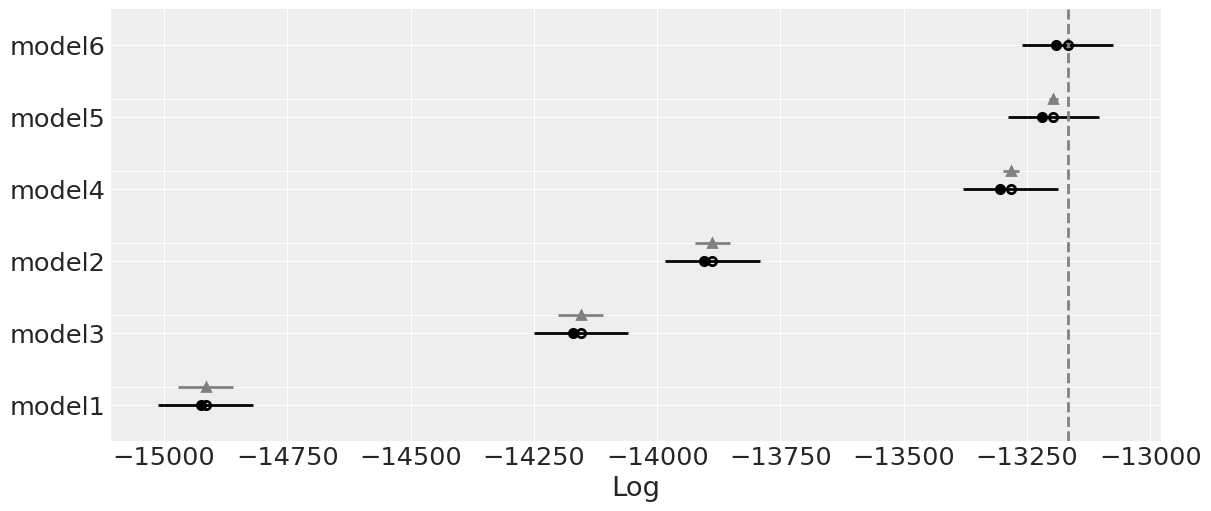

In [29]:
az.plot_compare(df_compare, figsize=(12, 5));

The difference between the models with cubic terms (models 5 and 6) and model 4 is not large enough to consider them above the latter (there's overlap between their interval estimations). Consequently, we select model 4 and continue the work with it.

## Probability estimation

In this section we plot age vs the probability of making more than 50K a year given different profiles. As a reminder:

* Sex: 0-Male, 1-Female
* Race: 0-Black, 1-White

In [30]:
# This is just a function that given a set of predictor variables 
# returns the probability of success estimated by the model
def get_probability(trace, age, hs_week, sex, race, education_hs, education_undergrad, education_grad):
    variables = {
        "Intercept": 1, "age": age / 10, "age2": (age / 10) ** 2, "hs_week": hs_week / 10, 
        "hs_week2": (hs_week / 10) ** 2, "sex": sex, "race": race, "education_hs" : education_hs, 
        "education_undergrad": education_undergrad, "education_grad": education_grad
    }
    coefficients = {}
    for key in list(variables.keys()):
        coefficients[key] = trace[key]
    
    eta = np.dot(np.array(list(coefficients.values())), np.array(list(variables.values())))
    prob = 1 / (1 + np.exp(-eta))
    return prob

In [31]:
# Helper function used by `plot_ppd()`. 
# It generates lineplots for a given profile.
def ppd(trace, vals, lm, samples, ax, **kwargs):
    for loc in np.random.randint(0, len(trace), samples):
        sample = trace[loc]
        ax.plot(vals, lm(vals, sample), **kwargs)

In [36]:
def plot_ppd(trace, kwarglist, colors, labels, figsize=(8, 6)):
    fig, ax = plt.subplots(figsize=figsize) 
    handles = []
    ages = np.linspace(25, 75, 500)
    
    for idx, kwargs in enumerate(kwarglist):
        lm = lambda ages, samples: get_probability(samples, ages, **kwargs)
        ppd(trace, ages, lm, samples=100, color=colors[idx], ax=ax, alpha=.5, lw=1)
        handles.append(mlines.Line2D([], [], color=colors[idx], label=labels[idx], lw=3))
        
    ax.legend(handles=handles, loc='upper left')
    ax.set_ylabel('P(Income > $50K)')
    ax.set_xlabel('Age')
    return ax

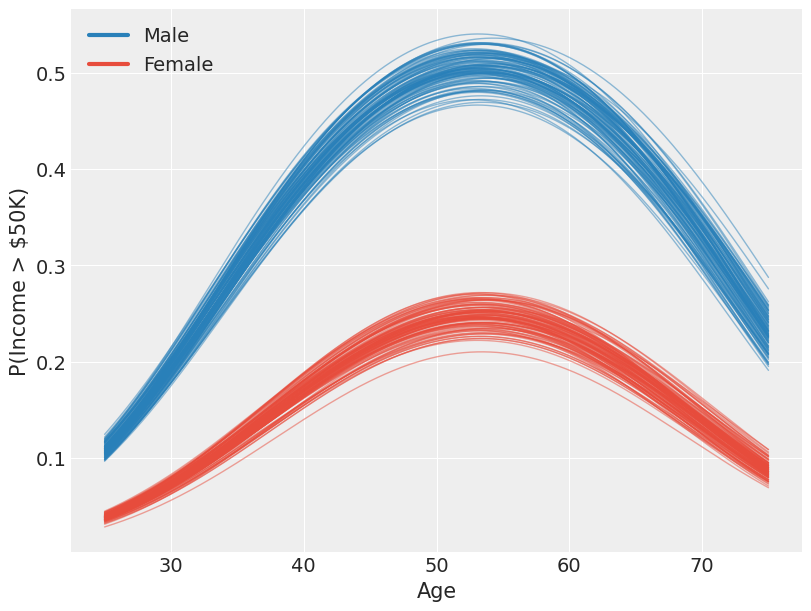

In [37]:
kwarglist = [
    {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 1,
    'education_grad': 0
    }, {
    'hs_week': 40,
    'sex': 1,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 1,
    'education_grad': 0
    }
]
colors = [BLUE, RED]
labels = ['Male', 'Female']
plot_ppd(trace4, kwarglist, colors, labels);

7

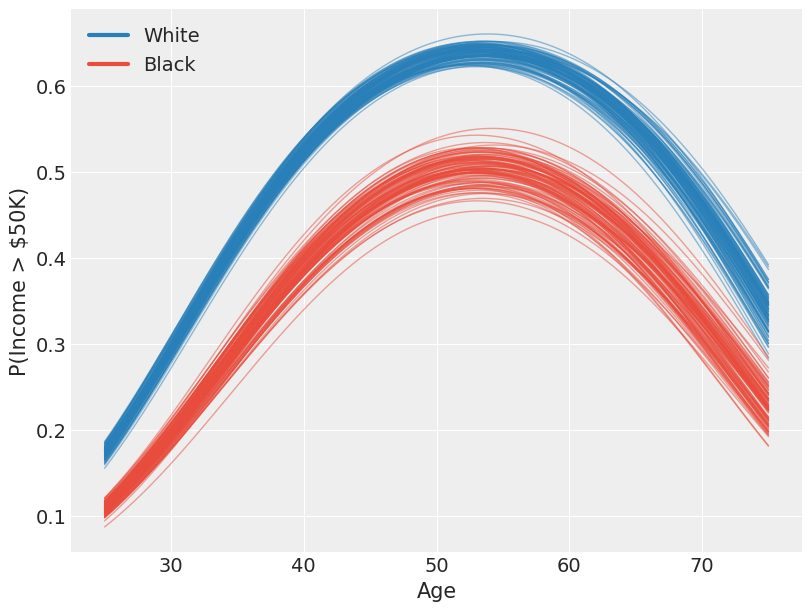

In [38]:
kwarglist = [
    {
    'hs_week': 40,
    'sex': 0,
    'race': 1,
    'education_hs': 0,
    'education_undergrad': 1,
    'education_grad': 0
    }, {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 1,
    'education_grad': 0
    }
]
colors = [BLUE, RED]
labels = ['White', 'Black']
plot_ppd(trace4, kwarglist, colors, labels);7

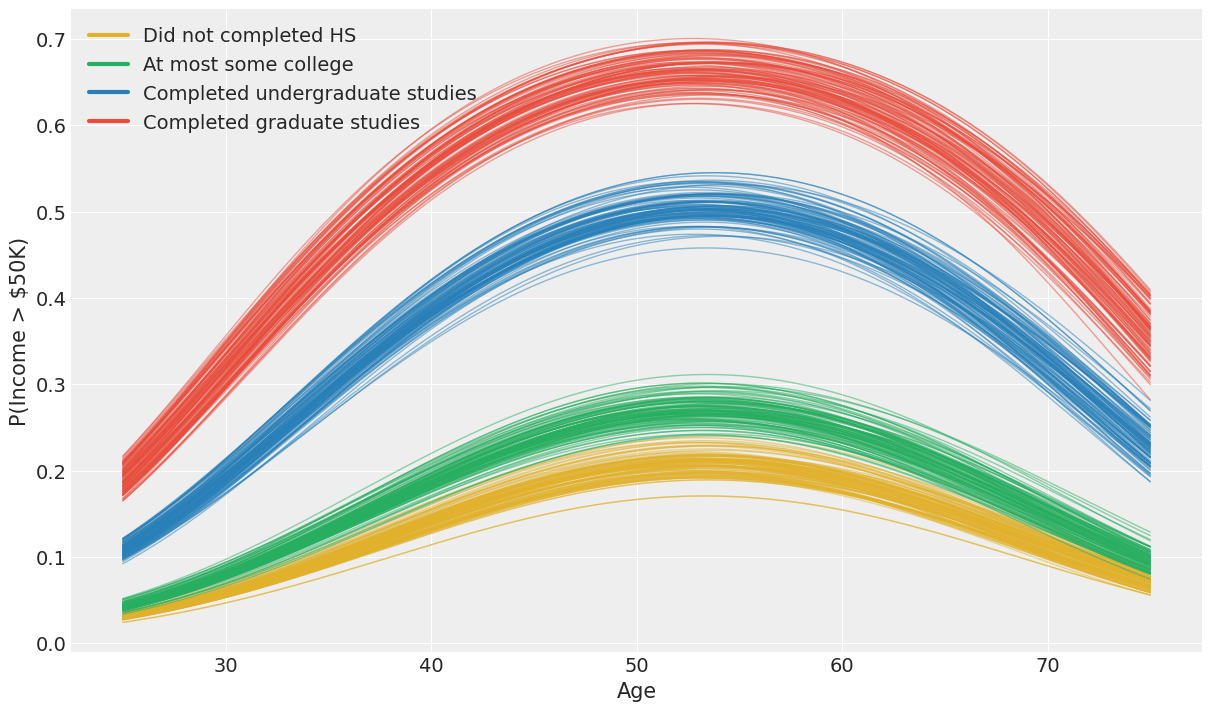

In [40]:
kwarglist = [
    {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 0,
    'education_grad': 0
    }, {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 1,
    'education_undergrad': 0,
    'education_grad': 0
    }, {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 1,
    'education_grad': 0
    }, {
    'hs_week': 40,
    'sex': 0,
    'race': 0,
    'education_hs': 0,
    'education_undergrad': 0,
    'education_grad': 1
    }
]
colors = [YELLOW, GREEN, BLUE, RED]
labels = ['Did not completed HS', 'At most some college', 
          'Completed undergraduate studies', 'Completed graduate studies']
plot_ppd(trace4, kwarglist, colors, labels, figsize=(12, 7));

## Odds ratios

We visualize the posterior distribution of different odds ratios with a 95% probability interval indicated by a black horizontal line. Here we are going to represent the coefficients for the education dummy variables as $\beta_0$, $\beta_1$, and $\beta_2$. The following plot shows the odds ratios for the education categories where the denominator is always the baseline category 'Did not completed HS'.

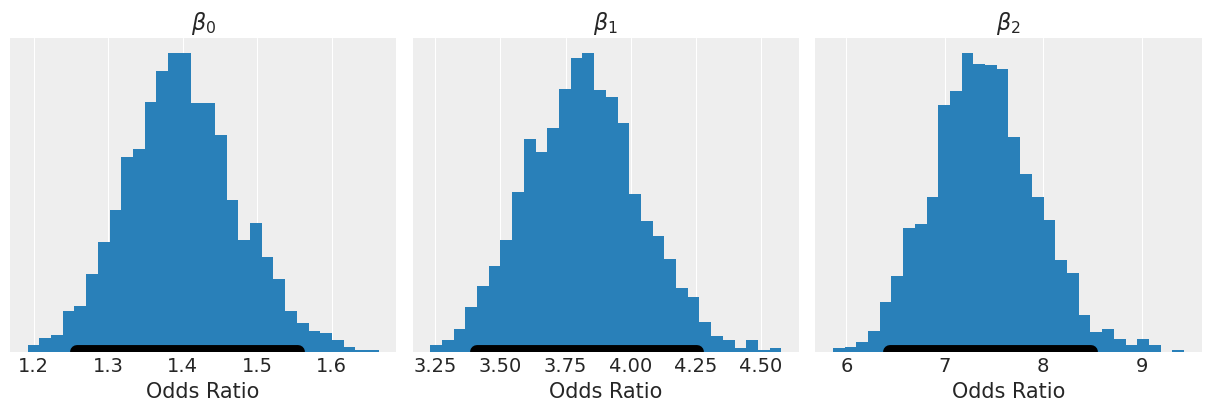

In [45]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

lvls = ['education_hs', 'education_undergrad', 'education_grad']
for idx, lvl in enumerate(lvls):
    coef = trace4[lvl]
    
    lb, ub = np.percentile(coef, [2.5, 97.5])
    ax[idx].hist(np.exp(coef), bins=30, color=BLUE, density=True)
    ax[idx].plot([np.exp(lb), np.exp(ub)], [0, 0], color='black', lw=10)
    ax[idx].set_title(rf'$\beta_{idx}$')
    ax[idx].set_xlabel('Odds Ratio')
    ax[idx].set_yticks([])

Since the variable education presents an order, odds ratios can be calculated to compare a given category vs. the previous one (e.g. Undergraduate vs. HS) instead of always using those who did not finish high school as a baseline (the first category). This allows us to see between which levels there is the greatest odds ratio.

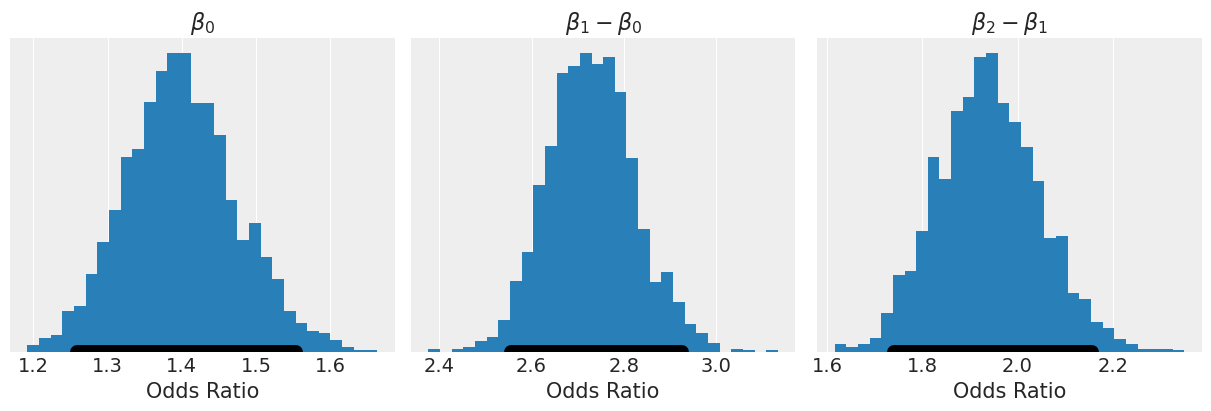

In [46]:
fig, ax = plt.subplots(ncols=3, figsize=(12, 4))

lvls = ['education_hs', 'education_undergrad', 'education_grad']

for idx, lvl in enumerate(lvls):
    coef_curr = trace4[lvl]
    
    if idx > 0:
        coef_prev = trace4[lvls[idx - 1]]
        title = rf'$\beta_{idx} - \beta_{idx - 1}$'
    else:
        coef_prev = 0
        title = rf'$\beta_{idx}$'
        
    coef_diff = coef_curr - coef_prev
    lb, ub = np.percentile(coef_diff, [2.5, 97.5])
    
    ax[idx].hist(np.exp(coef_diff), bins=30, color=BLUE, density=True)
    ax[idx].plot([np.exp(lb), np.exp(ub)], [0, 0], color='black', lw=10)
    ax[idx].set_title(title)
    ax[idx].set_xlabel('Odds Ratio')
    ax[idx].set_yticks([])

For example, the mean odds ratio between 'Completed undergraduate studies' and 'At most some college' is around 2.7 which means that on average the probability of making more than 50k a year is 2.7 larger for those who completed undergraduate studies than those who at most went to college but did not graduated.

In none of the cases the intervals cover the number 1, which means the data suggest there is a real difference in the probability of making more than 50k a year between the different eduaction levels we specified in the model.